this code is about the classification of the chest CT images into one of the four cancerous conditions namely adenocarcinoma, large cell carcinoma, squamous cell carcinoma and normal.

In [1]:
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.models import * 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import EfficientNetB7
import scipy

2022-12-04 17:15:45.592508: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/shreeyakhurana/opt/anaconda3/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.11.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matr

In [2]:
path = './../10-617-Project'

In [3]:
train_datagen = image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)
val_datagen= image.ImageDataGenerator(    
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1)
test_datagen= image.ImageDataGenerator(    
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1)

In [4]:
train_generator = train_datagen.flow_from_directory(
    f'{path}/Data/train',
    target_size = (224,224),
    batch_size = 32,
    shuffle=True,
    class_mode = 'categorical')
    
validation_generator = val_datagen.flow_from_directory(
    f'{path}/Data/valid',
    target_size = (224,224),
    batch_size = 1,
    shuffle=True,
    class_mode = 'categorical')

test_generator = test_datagen.flow_from_directory(
    f'{path}/Data/test',
    target_size = (224,224),
    batch_size = 1,
    shuffle=True,
    class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


I have developed a transfer learning based EfficientNetB3 model that has been trained on imagenet dataset. I have added some additional layers to the basic model.

In [11]:
#base_model = EfficientNetB7(weights='imagenet', classifier_activation="softmax", include_top=False)
base_model = EfficientNetB0(weights='imagenet', classifier_activation="softmax", include_top=False)

print(len(base_model.layers))
#print("Layers:", base_model.layers)
lr = 0.1
lr_mult = 0.9

parameters = []

i = 0
for layer in base_model.layers:
    layer.trainable=True

model = Sequential()
model.add(base_model)
model.add(GlobalMaxPooling2D(name="gap"))
model.add(Dense(4, activation='softmax'))
model.summary()


#model.compile(loss='categorical_crossentropy',
              #optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
              #metrics=['accuracy','AUC','Precision','Recall'])
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.0001,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=False)
optimizers = [tf.keras.optimizers.Adam(learning_rate = lr_schedule), tf.keras.optimizers.Adam(learning_rate = 0.0001)]
optimizers_and_layers = [(optimizers[0], model.layers[0]), (optimizers[1], model.layers[1:])]

model.compile(loss='categorical_crossentropy',
              optimizer=tfa.optimizers.MultiOptimizer(optimizers_and_layers),
              metrics=['accuracy','AUC','Precision','Recall'])
              
#model.compile(loss='categorical_crossentropy',
              #optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
              #metrics=['accuracy','AUC','Precision','Recall'])

238
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 gap (GlobalMaxPooling2D)    (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 4,054,695
Trainable params: 4,012,672
Non-trainable params: 42,023
_________________________________________________________________


In [12]:
#base_model.summary()

In [13]:

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    )

Epoch 1/30
20/20 [==============================] - 109s 4s/step - loss: 3.7032 - accuracy: 0.3409 - auc: 0.6224 - precision: 0.3477 - recall: 0.3295 - val_loss: 2.7356 - val_accuracy: 0.3333 - val_auc: 0.5985 - val_precision: 0.3485 - val_recall: 0.3194
Epoch 2/30
20/20 [==============================] - 79s 4s/step - loss: 1.5298 - accuracy: 0.5873 - auc: 0.8283 - precision: 0.6041 - recall: 0.5726 - val_loss: 2.6352 - val_accuracy: 0.3750 - val_auc: 0.6346 - val_precision: 0.3803 - val_recall: 0.3750
Epoch 3/30
20/20 [==============================] - 78s 4s/step - loss: 0.9649 - accuracy: 0.6852 - auc: 0.8944 - precision: 0.6914 - recall: 0.6688 - val_loss: 2.3951 - val_accuracy: 0.4583 - val_auc: 0.7050 - val_precision: 0.4706 - val_recall: 0.4444
Epoch 4/30
20/20 [==============================] - 78s 4s/step - loss: 0.7751 - accuracy: 0.7357 - auc: 0.9199 - precision: 0.7590 - recall: 0.7243 - val_loss: 1.9454 - val_accuracy: 0.4861 - val_auc: 0.7290 - val_precision: 0.4853 - va

In [14]:
print(history.history.keys())
h = history.history
print(h['val_accuracy'])

dict_keys(['loss', 'accuracy', 'auc', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_auc', 'val_precision', 'val_recall'])
[0.3333333432674408, 0.375, 0.4583333432674408, 0.4861111044883728, 0.5555555820465088, 0.4722222089767456, 0.5555555820465088, 0.5833333134651184, 0.5694444179534912, 0.6527777910232544, 0.6666666865348816, 0.6527777910232544, 0.6805555820465088, 0.6527777910232544, 0.6805555820465088, 0.6527777910232544, 0.6805555820465088, 0.7638888955116272, 0.7222222089767456, 0.7361111044883728, 0.75, 0.6805555820465088, 0.8055555820465088, 0.7777777910232544, 0.75, 0.8333333134651184, 0.8611111044883728, 0.8611111044883728, 0.7777777910232544, 0.875]


['loss', 'accuracy', 'auc', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_auc', 'val_precision', 'val_recall']
loss loss val_loss


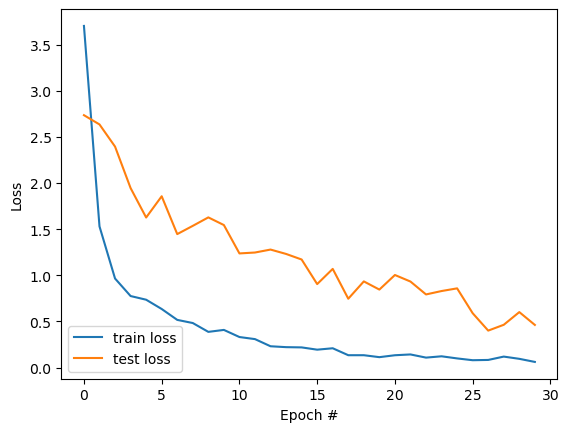

accuracy accuracy val_accuracy


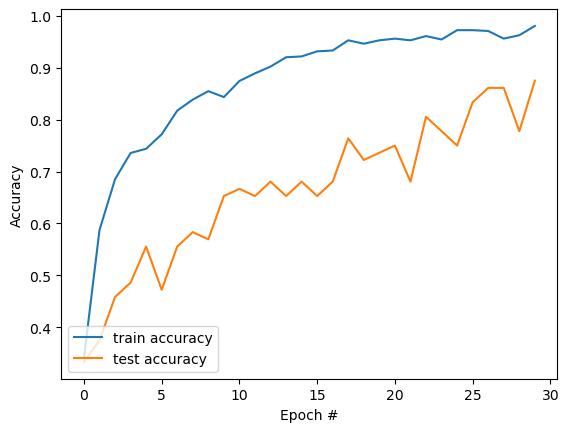

precision auc val_auc


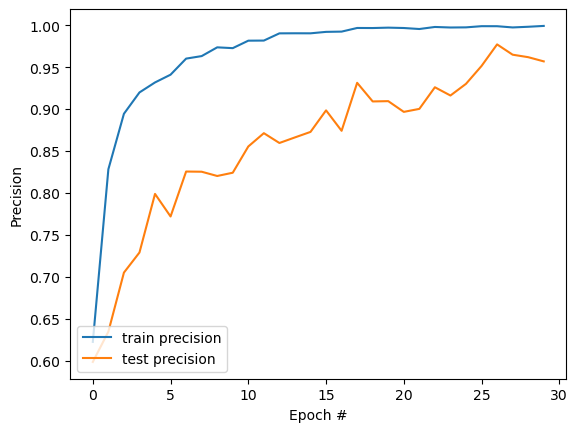

recall recall val_recall


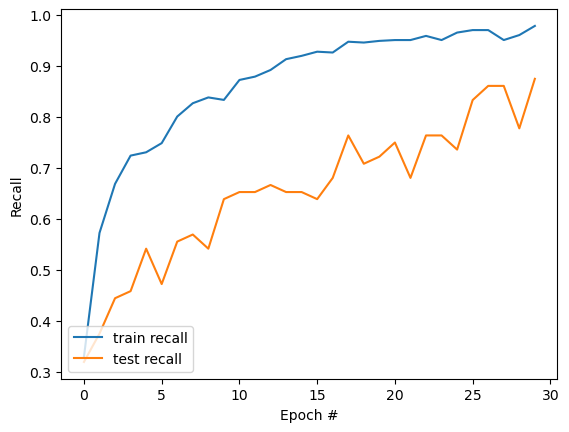

<Figure size 640x480 with 0 Axes>

In [15]:
hdict = history.history
keys = list(hdict.keys())
print(keys)
def graph(name, index):
    print(name, keys[index], keys[(len(keys) // 2) + index])
    train_metric, test_metric = hdict[keys[index]], hdict[keys[(len(keys) // 2) + index]]
    epochs = len(train_metric)
    x = list(range(epochs))

    plt.plot(x, train_metric, label=f'train {name}')
    plt.plot(x, test_metric, label=f'test {name}')

    plt.xlabel('Epoch #')
    plt.ylabel(name.capitalize())
    plt.legend(loc='lower left')
    plt.savefig(f'./initial_plots/{name}.png')
    plt.show()
    plt.clf()

graph('loss', 0)
graph('accuracy', 1)
graph('precision', 2)
graph('recall', 4)

In [16]:
model.evaluate(train_generator)

20/20 [==============================] - 19s 930ms/step - loss: 0.0684 - accuracy: 0.9772 - auc: 0.9991 - precision: 0.9771 - recall: 0.9739


[0.06836698204278946,
 0.9771615266799927,
 0.9991289973258972,
 0.9770867228507996,
 0.9738988876342773]

In [17]:
model.evaluate(validation_generator)


72/72 [==============================] - 3s 39ms/step - loss: 0.5156 - accuracy: 0.8194 - auc: 0.9588 - precision: 0.8194 - recall: 0.8194


[0.5155884623527527,
 0.8194444179534912,
 0.9588155746459961,
 0.8194444179534912,
 0.8194444179534912]

In [18]:
model.evaluate(test_generator)
# loss, 'accuracy','AUC','Precision','Recall'

315/315 [==============================] - 13s 42ms/step - loss: 0.4835 - accuracy: 0.8381 - auc: 0.9696 - precision: 0.8534 - recall: 0.8317


[0.4834965169429779,
 0.8380952477455139,
 0.9695624709129333,
 0.8534201979637146,
 0.8317460417747498]

In [19]:
# from keras.preprocessing import image
# img = image.load_img('/content/Data/valid/squamous_cell_carcinoma_left.lower.lobe_T2_N0_M0_Ib/000117 (6).png',target_size=(224,224))
# imag = image.img_to_array(img)
# imaga = np.expand_dims(imag,axis=0) 
# ypred = model.predict(imaga)
# print(ypred)
# a=np.argmax(ypred,-1)
# if a==0:
#   op="Adenocarcinoma"
# elif a==1:
#   op="large cell carcinoma"
# elif a==2:
#   op="normal (void of cancer)"
# else:
#   op="squamous cell carcinoma"    
# plt.imshow(img)
# print("THE UPLOADED IMAGE IS SUSPECTED AS: "+str(op))  


In [20]:
tf.keras.models.save_model(model,'mymodel.hdf5')

TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.